In [13]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import cv2
import numpy as np

In [14]:
import sys
sys.path.append('./ssd_keras/')

In [15]:
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
from scipy.misc import imread
import tensorflow as tf
from ssd_keras.ssd import SSD300
from ssd_utils import BBoxUtility

In [16]:
import time
proc_times=[]

In [17]:
voc_classes = ['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle',
               'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable',
               'Dog', 'Horse','Motorbike', 'Person', 'Pottedplant',
               'Sheep', 'Sofa', 'Train', 'Tvmonitor']
NUM_CLASSES = len(voc_classes) + 1

In [18]:
input_shape=(300, 300, 3)
model = SSD300(input_shape, num_classes=NUM_CLASSES)
model.load_weights('ssd_keras/weights_SSD300.hdf5', by_name=True)
bbox_util = BBoxUtility(NUM_CLASSES)

In [19]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 300, 300, 3)   0                                            
____________________________________________________________________________________________________
conv1_1 (Convolution2D)          (None, 300, 300, 64)  1792        input_2[0][0]                    
____________________________________________________________________________________________________
conv1_2 (Convolution2D)          (None, 300, 300, 64)  36928       conv1_1[0][0]                    
____________________________________________________________________________________________________
pool1 (MaxPooling2D)             (None, 150, 150, 64)  0           conv1_2[0][0]                    
___________________________________________________________________________________________

In [20]:
def image_pipeline(img):
#     accepts color image;
    _t_start=time.time()
#     resize image to 300,300
    rsz=cv2.resize(img,(300,300)).reshape(-1,300,300,3).astype(np.float64)
#     Predict the results
    preds=model.predict(preprocess_input(rsz))
#     Get the bounding boxes
    results=bbox_util.detection_out(preds)
#     Get only the car class - 7
    det_label = results[0][:, 0]
    det_conf  = results[0][:, 1]    
    car_inds=np.logical_and(det_conf>0.6,det_label==7)
    det_xmin  = results[0][:, 2][car_inds]
    det_ymin  = results[0][:, 3][car_inds]
    det_xmax  = results[0][:, 4][car_inds]
    det_ymax  = results[0][:, 5][car_inds]
    img_drw=np.copy(img)
    for i in range(len(det_ymin)):
        (x1,y1)=int(img.shape[1]*det_xmin[i]),int(img.shape[0]*det_ymin[i])
        (x2,y2)=int(img.shape[1]*det_xmax[i]),int(img.shape[0]*det_ymax[i])
        cv2.rectangle(img_drw,(x1,y1),(x2,y2),(255,255,255),5)    
#     Append time interval for processing image.
    proc_times.append(time.time()-_t_start)
    return img_drw

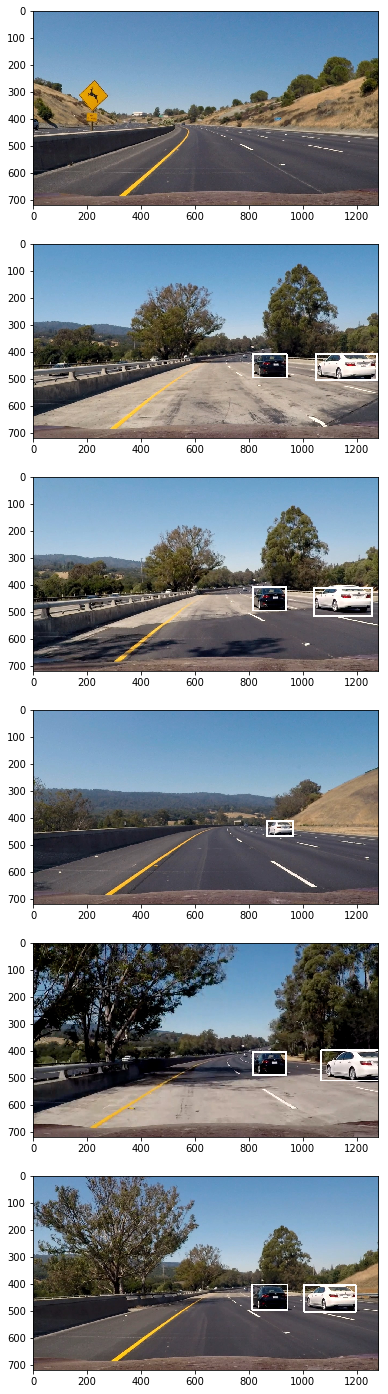

In [21]:
import glob

test_files=glob.glob('../test_images/*.jpg')
total_files=len(test_files)
fig=plt.figure(figsize=(10,25))
for i in range(total_files):
    plt.subplot(total_files,1,i+1)
    img=cv2.cvtColor(cv2.imread(test_files[i]),cv2.COLOR_BGR2RGB)
    output=image_pipeline(img)
    plt.imshow(output)

In [22]:
from moviepy.editor import VideoFileClip
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(image_pipeline) #NOTE: this function expects color images!!
out_file="ssd_output.mp4"
%time white_clip.write_videofile(out_file, audio=False)


[MoviePy] >>>> Building video ssd_output.mp4
[MoviePy] Writing video ssd_output.mp4


100%|█████████▉| 1260/1261 [00:26<00:00, 47.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ssd_output.mp4 

CPU times: user 17.5 s, sys: 1.06 s, total: 18.6 s
Wall time: 27.4 s


In [23]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(out_file))

In [24]:
print("Average framerate processed: {:.3f} fps".format(len(proc_times)/sum(proc_times)))

Average framerate processed: 52.751 fps
